Value iteration completed
[  0.08] Call1(Type 2) arrived
[  0.10] Call 1 (Type 2) assigned to Agent_2, waited  0.02 mins
[  0.25] Call2(Type 2) arrived
[  0.30] Call 2 (Type 2) assigned to Agent_3, waited  0.05 mins
[0.44] Agent_2 finished call 1
[  0.73] Call3(Type 1) arrived
[  0.80] Call 3 (Type 1) assigned to Agent_1, waited  0.07 mins
[0.81] Agent_1 finished call 3
[  0.98] Call4(Type 2) arrived
[  1.04] Call 4 (Type 2) assigned to Agent_2, waited  0.06 mins
[1.08] Agent_3 finished call 2
[  1.33] Call5(Type 1) arrived
[  1.38] Call 5 (Type 1) assigned to Agent_3, waited  0.05 mins
[  1.45] Call6(Type 2) arrived
[1.53] Agent_3 finished call 5
[  1.53] Call 6 (Type 2) assigned to Agent_3, waited  0.08 mins
[1.61] Agent_3 finished call 6
[  1.75] Call7(Type 2) arrived
[1.75] Agent_2 finished call 4
[  1.75] Call 7 (Type 2) assigned to Agent_2, waited  0.00 mins
[  1.85] Call8(Type 2) arrived
[  1.91] Call 8 (Type 2) assigned to Agent_3, waited  0.06 mins
[1.96] Agent_2 finished call

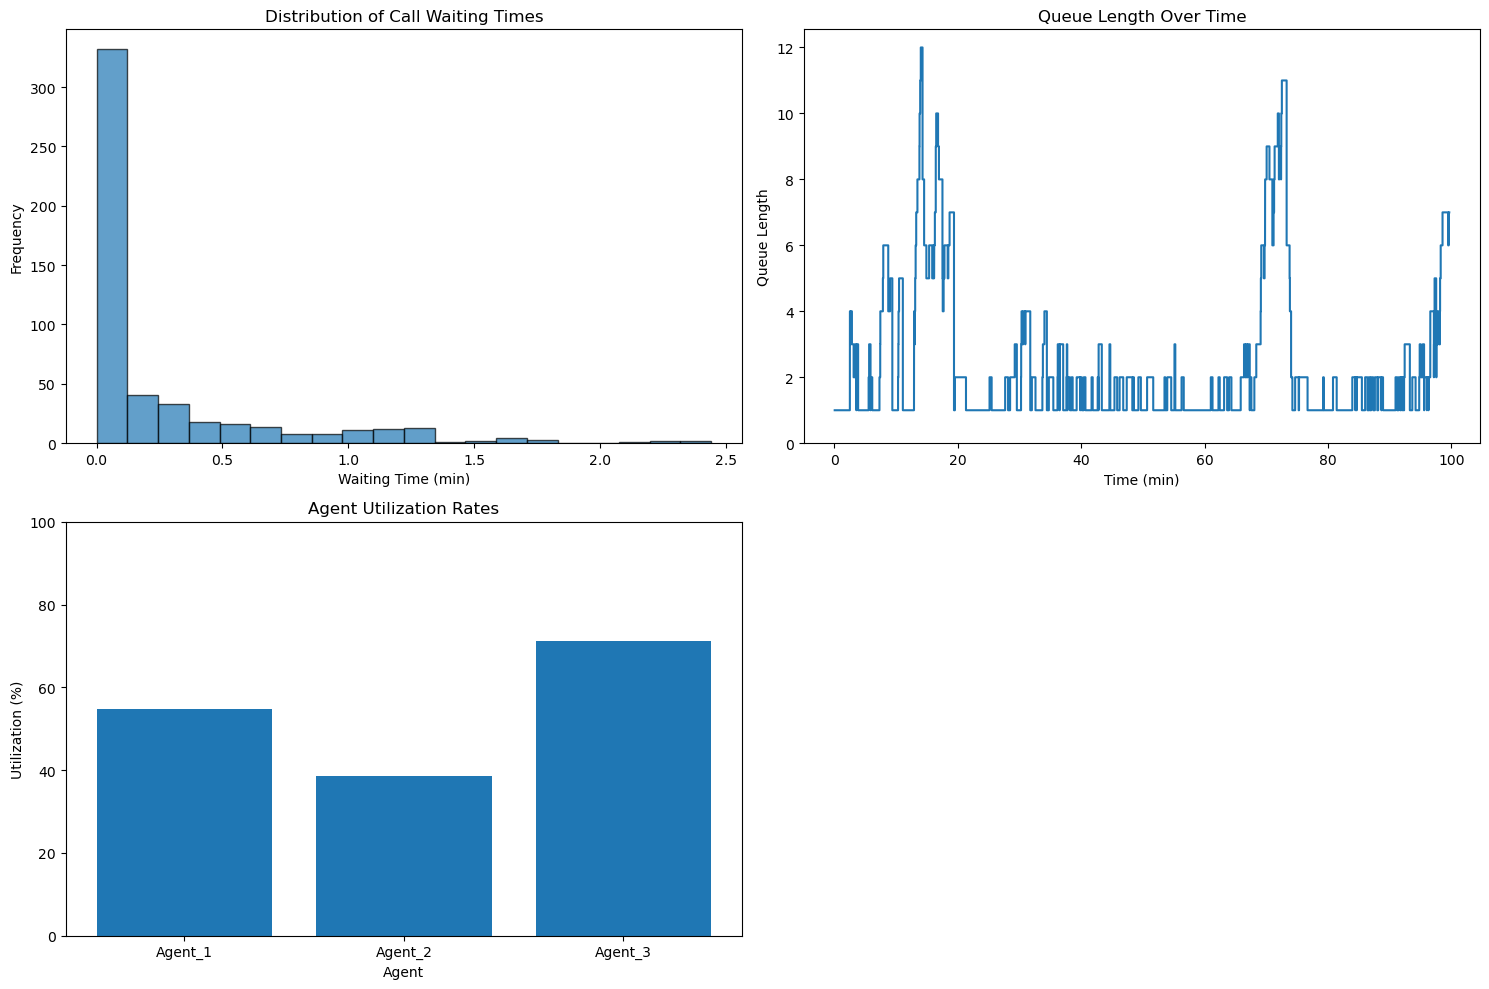

In [65]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt


#setting parameters
sim_time = 100
arrival_rate = 5
call_probs = [0.6,0.4]
service_rate = 3
agent_skills = {
    'Agent_1': [1],
    'Agent_2': [2],
    'Agent_3': [1,2],
}
max_wait_list =20
gamma =0.9  
type_bonus = {1:1.0, 2:0.5}
V = {}       

def initialize_value_function():
    for call_type in [1,2]:
        for wait_list in range(max_wait_list+1):
            V[(call_type,wait_list)] = 0

def reward(state):
    call_type,wait_list = state
    return -(wait_list + type_bonus.get(call_type, 0))  

def value_iteration():
    threshold =0.01
    delta = 1
    actions = list(agent_skills.keys()) + ['wait']
    
    while delta>threshold:
        delta =0
        for state in V:
            old_value = V[state]
            action_values = []
            #evaluating all possible actions
            for action in actions:
                if action =='wait':
                    value = reward(state)+gamma*V[state]
                else:
                    new_state = (state[0],0)
                    value = reward(state)+gamma*V[new_state]
                action_values.append(value)
            
            V[state] = min(action_values) 
            delta = max(delta, abs(old_value - V[state]))
    print("Value iteration completed")
    
#simulation setup
def generate_calls(env,queue,arrival_rate, call_probs):
    id =0
    while True:
        interarrival =np.random.exponential(1/ arrival_rate)
        yield env.timeout(interarrival)
        id = id+1
        type = np.random.choice([1,2],p=call_probs)
        call ={'id':id, 'type':type, 'arrival':env.now}
        queue.append(call)
        #capturing queue length over time
        q_length_history.append(len(queue))
        arrival_times.append(env.now)
        print(f"[{env.now:6.2f}] Call{id}(Type {type}) arrived")

def get_state(call, current_time):
    waiting_time = current_time - call['arrival']
    waiting_bucket = min(int(waiting_time), max_wait_list)
    return (call['type'], waiting_bucket)

def value_based_policy(eligible_calls, current_time, agent_id):
    available_calls = []
    for call in eligible_calls:
        state = get_state(call, current_time)
        value = V.get(state, 0.0)
        available_calls.append((call, state, value))
    if not available_calls:
        return None
    #choosing call to assign
    chosen_call, state, _ = min(available_calls, key=lambda x: x[2])
    return chosen_call, state

def agent_process(env,agent_id,skills,call_q, service_rate, wait_times, decision_policy):
    while True:
        #checking for eligible calls
        eligible_calls = [call for call in call_q if call['type'] in skills]
        
        if eligible_calls:
            selected_call, state = decision_policy(eligible_calls, env.now, agent_id)
            if selected_call:
                call_q.remove(selected_call)
                wait_time = env.now-selected_call['arrival']
                wait_times.append(wait_time)
                start_time = env.now
                print(f"[{env.now:6.2f}] Call {selected_call['id']} (Type {selected_call['type']}) assigned to {agent_id}, waited {wait_time:5.2f} mins")
                service_duration = np.random.exponential(1/service_rate)
                yield env.timeout(service_duration)
                agent_busy_time[agent_id] += env.now-start_time
                print(f"[{env.now:4.2f}] {agent_id} finished call {selected_call['id']}")
        else:
            yield env.timeout(0.1)

def run_simulation(sim_time, arrival_rate, call_probs, agent_skills, service_rate, decision_policy):
    env = simpy.Environment()
    call_q =[]
    wait_times =[]
    #tracking variables
    global agent_busy_time, q_length_history, arrival_times
    agent_busy_time = {}
    for agent in agent_skills:
        agent_busy_time[agent] = 0
    q_length_history =[]
    arrival_times =[]
    env.process(generate_calls(env, call_q, arrival_rate, call_probs))
    for agent_id, skills in agent_skills.items():
        env.process(agent_process(env,agent_id,skills, call_q, service_rate, wait_times, decision_policy))
    env.run(until=sim_time)
    return wait_times

#executing simulation
initialize_value_function()
value_iteration()
wait_times = run_simulation(sim_time,arrival_rate,call_probs,agent_skills,service_rate,value_based_policy)

#printing waiting time
if wait_times:
    avg_wait = np.mean(wait_times)
    print(f"\nAverage waiting time is {avg_wait:.2f} minutes")
else:
    print("\nNo calls served")

#calculating agent utilization rates
print("\nAgent Utilization Rates:")
for agent, busy_time in agent_busy_time.items():
    utilization = (busy_time/sim_time) * 100
    print(f"{agent}: {utilization:.2f}%")

#plotting waiting time distribution
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(wait_times, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Waiting Time (min)")
plt.ylabel("Frequency")
plt.title("Distribution of Call Waiting Times")

#plottimng queue lengths over time
plt.subplot(2, 2, 2)
plt.step(arrival_times, q_length_history, where='post')
plt.xlabel("Time (min)")
plt.ylabel("Queue Length")
plt.title("Queue Length Over Time")
plt.ylim(bottom=0)

#plotting agent utilization rates
plt.subplot(2, 2, 3)
utilization = [agent_busy_time[agent]/sim_time*100 for agent in agent_skills]
plt.bar(agent_skills.keys(), utilization)
plt.xlabel("Agent")
plt.ylabel("Utilization (%)")
plt.title("Agent Utilization Rates")
plt.ylim(0,100)

plt.tight_layout()
plt.show()
